

#  광고 클릭율 예측을 위한 모델 개발

- **대용량 데이터**  
 대규모 데이터셋으로 구성이 되어 있어서 duckdb 라이브러리로 데이터를 랜덤 추출해서 샘플링 진행


- **데이터 불균형**

 광고 클릭 데이터는 일반적으로 많은 수의 '클릭하지 않음'과 상대적으로 적은 수의 '클릭' 사례를 포함하고 있어, 데이터의 불균형이 존재했다.
duckdb 라이브러리로 데이터를 랜덤 추출해서 샘플링 진행하여 의도적으로

- **고차원의 범주형 데이터**

웹 로그 데이터셋은 종종 고차원의 범주형 특성을 포함합니다.
이러한 특성은 매우 높은 cardinality를 가지며, 효과적인 특성 처리 및 인코딩 방법이 요구됩니다.


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.9 MB/s eta 0:00:00


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.6 MB/s eta 0:00:00


In [ ]:
# import

import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import duckdb

import plotly.express as px
from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [ ]:
# seed 고정

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

In [ ]:
# 데이터 읽기 (train.csv파일이 대용량이여서 duckdb 라이브러리를 활용하여, 데이터 중 일부 데이터만 불러옴)
# 클릭한 데이터의 중요성, 클래스 불균형 문제 해결, 모델 학습의 효율성 향상, 검증 및 테스트의 신뢰성 확보, 비즈니스 목표 및 사용자 행동 분석을 위해
train_path = '/content/drive/MyDrive/zerobase/광고클릭률예측/open/train.csv'

con = duckdb.connect()

df = con.query(f"""(SELECT *
                        FROM read_csv_auto('{train_path}')
                        WHERE Click = 0
                        ORDER BY random()
                        LIMIT 100000)
                        UNION ALL
                        (SELECT *
                        FROM read_csv_auto('{train_path}')
                        WHERE Click = 1
                        ORDER BY random()
                        LIMIT 556986)""").df()


con.close()

df.head()

KeyboardInterrupt: 

In [ ]:
df.to_csv('/content/drive/MyDrive/zerobase/광고클릭률예측/open/train_sam.csv', index=False)

In [ ]:
# 데이터 읽기
test = pd.read_csv('/content/drive/MyDrive/zerobase/광고클릭률예측/open/test.csv')
train = pd.read_csv('/content/drive/MyDrive/zerobase/광고클릭률예측/open/train_sam.csv')

# EDA  데이터 확인 & 결측치 제거

In [ ]:
train.shape

(656986, 41)

In [ ]:
train.describe()

,Click,F04,F06,F11,F14,F18,F19,F24,F27,F29,F32,F33,F36,F38
count,656986.000000,656986.000000,656986.000000,656986.000000,656986.000000,656986.000000,656986.000000,656986.000000,656986.000000,656986.000000,6.569860e+05,656986.000000,656986.000000,656986.000000
mean,0.847790,16.718320,135.146904,344.638152,9.438818,4.261522,0.451246,57.804920,23.843717,4.111794,1.182412e+04,2.749830,4.397133,0.268598
std,0.359225,312.801637,448.192346,595.341469,12.057050,6.922666,0.705801,403.191796,92.060538,8.566714,4.957036e+04,9.139742,9.804692,3.067098
min,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,26.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000e+01,0.000000,0.000000,0.000000
50%,1.000000,3.000000,5.000000,133.000000,4.000000,2.000000,0.000000,7.000000,3.000000,1.000000,1.441000e+03,0.000000,1.000000,0.000000
75%,1.000000,11.000000,55.000000,412.000000,13.000000,5.000000,1.000000,35.000000,15.000000,4.000000,6.984500e+03,2.000000,5.000000,0.000000
max,1.000000,65535.000000,13975.000000,8000.000000,517.000000,473.000000,9.000000,93277.000000,7543.000000,190.000000,2.285311e+06,954.000000,3343.000000,1205.000000


In [ ]:
train.isnull().sum()

,0
ID,0
Click,0
F01,0
F02,0
F03,0
F04,0
F05,0
F06,0
F07,0
F08,0


In [ ]:
train.dtypes

,0
ID,object
Click,int64
F01,object
F02,object
F03,object
F04,int64
F05,object
F06,int64
F07,object
F08,object


In [ ]:
float_columns = ["F04", "F11", "F18", "F19", "F24", "F27", "F29", "F32", "F33", "F36", "F38"]
categorical_columns = ["F01", "F02", "F03", "F05", "F07", "F08", "F09", "F10", "F12", "F13", "F15", "F16", "F17", "F20", "F21", "F22", "F23", "F25", "F26", "F28", "F30", "F31", "F34", "F35", "F37", "F39"]

for col in float_columns:
    train[col] = train[col].fillna(0)

train = train.fillna('Null')
train[float_columns] = train[float_columns].astype('int64')
train[categorical_columns] = train[categorical_columns].astype('category')

In [ ]:
# 결측치제거 -> 수치형변수의 결측치는 0으로 대체, 범주형변수의 결측치는 Null로 대체하여 결측치 제거
train.isnull().sum()

,0
ID,0
Click,0
F01,0
F02,0
F03,0
F04,0
F05,0
F06,0
F07,0
F08,0


In [ ]:
click = train['Click'].value_counts(normalize=True)

click_figure = px.bar(click,
             x=['Not Clicked : 0', 'Clicked : 1'],
             y=click.values.tolist(),
             labels={'x': 'Value', 'y': 'Percentage'},
             width = 450,
             height = 500
            )

click_figure.show()

print(train["Click"].value_counts())


Click
1    556986
0    100000
Name: count, dtype: int64


# Data Preprocessing
 : RAM사용량 최소화를 위한 라벨인코딩

In [ ]:
# train데이터 라벨 인코딩
mapping = {}

for col in categorical_columns:
    encoder = LabelEncoder()
    encoder.fit(train[col])
    train[col] = encoder.transform(train[col])
    mapping[col] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

In [ ]:
train.dtypes

,0
ID,object
Click,int64
F01,int64
F02,int64
F03,int64
F04,int64
F05,int64
F06,int64
F07,int64
F08,int64


In [ ]:
# mapping 딕셔너리
mapping

{'F01': {'AAABLBW': 0,
  'AAADGLC': 1,
  'AAADXJV': 2,
  'AAAEIDQ': 3,
  'AAAGEMG': 4,
  'AAAGUNH': 5,
  'AAAKMIV': 6,
  'AAAMMAF': 7,
  'AAANJZX': 8,
  'AAANYTQ': 9,
  'AAAOQJV': 10,
  'AAASOWT': 11,
  'AAASSIR': 12,
  'AAAUTLW': 13,
  'AAAVKIG': 14,
  'AABBHRO': 15,
  'AABDSZF': 16,
  'AABGWWL': 17,
  'AABIXFU': 18,
  'AABJEOQ': 19,
  'AABKORX': 20,
  'AABKXLP': 21,
  'AABMEZH': 22,
  'AABNNBC': 23,
  'AABOOXF': 24,
  'AABRUYH': 25,
  'AABSRTA': 26,
  'AABUMPW': 27,
  'AABZNUV': 28,
  'AACGMJI': 29,
  'AACHEYN': 30,
  'AACLFKL': 31,
  'AACLXCL': 32,
  'AACMQGG': 33,
  'AACNXJY': 34,
  'AACOMAL': 35,
  'AACOWOS': 36,
  'AACQOEB': 37,
  'AACTGST': 38,
  'AACYZTR': 39,
  'AACZODO': 40,
  'AADAHIT': 41,
  'AADAZMJ': 42,
  'AADBDWR': 43,
  'AADJBZW': 44,
  'AADKNBL': 45,
  'AADOWNH': 46,
  'AADQOJT': 47,
  'AADRKJN': 48,
  'AADVGMD': 49,
  'AADYWYH': 50,
  'AAEBMSP': 51,
  'AAEBRBS': 52,
  'AAEFLIH': 53,
  'AAEFYCP': 54,
  'AAEHSFT': 55,
  'AAEHUXC': 56,
  'AAEIQUD': 57,
  'AAEKMYB': 58,


In [ ]:
# test데이터 인코딩전에 null값 처리
for col in categorical_columns:
    if "Null" in mapping[col].keys():
        continue
    mapping[col]["Null"] = max(mapping[col].values()) + 1

In [ ]:
for col in categorical_columns:
    print(col)
    test[col] = test[col].map(mapping[col])
    if test[col].isna().sum() >= 1:
        test[col].fillna(mapping[col]["Null"], inplace=True)

F01
F02
F03
F05
F07
F08
F09
F10
F12
F13
F15
F16
F17
F20
F21
F22
F23
F25
F26
F28
F30
F31
F34
F35
F37
F39


In [ ]:
train.dtypes

,0
ID,object
Click,int64
F01,int64
F02,int64
F03,int64
F04,int64
F05,int64
F06,int64
F07,int64
F08,int64


# Catboost model training
- ram 사용량을 줄이고 학습 시간을 빠르게 하기 위해 data를 Pool 형태로 training
- snapshot을 저장해서 kernel이 죽는 경우를 대비하고 iteration을 조금씩 늘려가면서 학습 진행

In [ ]:
X = train[train.columns[2:]]
y = train['Click']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

train_pool = Pool(X_train, label=y_train)
validation_pool = Pool(X_test, label=y_test)

model = CatBoostClassifier(
    iterations=7000,
    learning_rate=0.1,
    depth=8,
    eval_metric='AUC',
    random_seed=42,
    verbose=1000,
    task_type="CPU",
)

model.fit(
    train_pool,
    eval_set=validation_pool,
    early_stopping_rounds=700,
    save_snapshot=False,
)

0:	test: 0.6533099	best: 0.6533099 (0)	total: 324ms	remaining: 37m 46s
1000:	test: 0.7448949	best: 0.7450402 (822)	total: 4m 32s	remaining: 27m 13s
2000:	test: 0.7448270	best: 0.7453634 (1724)	total: 9m	remaining: 22m 30s
Stopped by overfitting detector  (700 iterations wait)

bestTest = 0.7453634006
bestIteration = 1724

Shrink model to first 1725 iterations.


# 최적화작업


## Optuna

In [ ]:
# 목적함수 정의
def objective(trial):
    # 최적화할 하이퍼파라미터 설정
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 2.0),
        'eval_metric': 'AUC',
        'task_type': 'CPU',
        'logging_level': 'Silent',
        'random_seed': 42
    }

    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=validation_pool, early_stopping_rounds=100, verbose=False)

    # 모델 성능 평가
    preds = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, preds)

    return auc

In [ ]:
# Optuna 최적화 실행
import optuna

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best AUC score:", study.best_value)
print("Best parameters:", study.best_params)


[I 2024-08-25 02:05:42,130] A new study created in memory with name: no-name-22a86389-ea10-4a50-96f4-f3a3b6649113
[I 2024-08-25 02:06:30,561] Trial 0 finished with value: 0.7115276245294236 and parameters: {'iterations': 188, 'depth': 7, 'learning_rate': 0.03646577447114959, 'random_strength': 3.152754172489044, 'bagging_temperature': 0.6944524259260052, 'border_count': 119, 'l2_leaf_reg': 7.785539951218958, 'scale_pos_weight': 0.6778578094200611}. Best is trial 0 with value: 0.7115276245294236.
[I 2024-08-25 02:07:33,254] Trial 1 finished with value: 0.6974856160741453 and parameters: {'iterations': 346, 'depth': 4, 'learning_rate': 0.02577612007822567, 'random_strength': 8.227484415905066, 'bagging_temperature': 0.09883883358806189, 'border_count': 133, 'l2_leaf_reg': 7.84853855672358, 'scale_pos_weight': 1.7480163114439622}. Best is trial 0 with value: 0.7115276245294236.
[I 2024-08-25 02:09:03,268] Trial 2 finished with value: 0.723259300509892 and parameters: {'iterations': 503, '

Best AUC score: 0.7455037783353915
Best parameters: {'iterations': 716, 'depth': 6, 'learning_rate': 0.1434452681311719, 'random_strength': 9.636924231305613, 'bagging_temperature': 0.8801310826837648, 'border_count': 181, 'l2_leaf_reg': 4.3754592812493405, 'scale_pos_weight': 0.5297966866606383}


## feature_importances
-> 피쳐 중요도를 추출해서 제외를 시켜 모델학습을 시켜봤지만 좋은 효율을 얻지는 못했음


In [ ]:
# 피처 중요도 추출
feature_importances = model.get_feature_importance()

# 피처 이름과 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
31,F32,6.039406
20,F21,4.802087
38,F39,4.137952
24,F25,3.710114
36,F37,3.644423
3,F04,3.631028
8,F09,3.621948
23,F24,3.576730
12,F13,3.557947
1,F02,3.545159


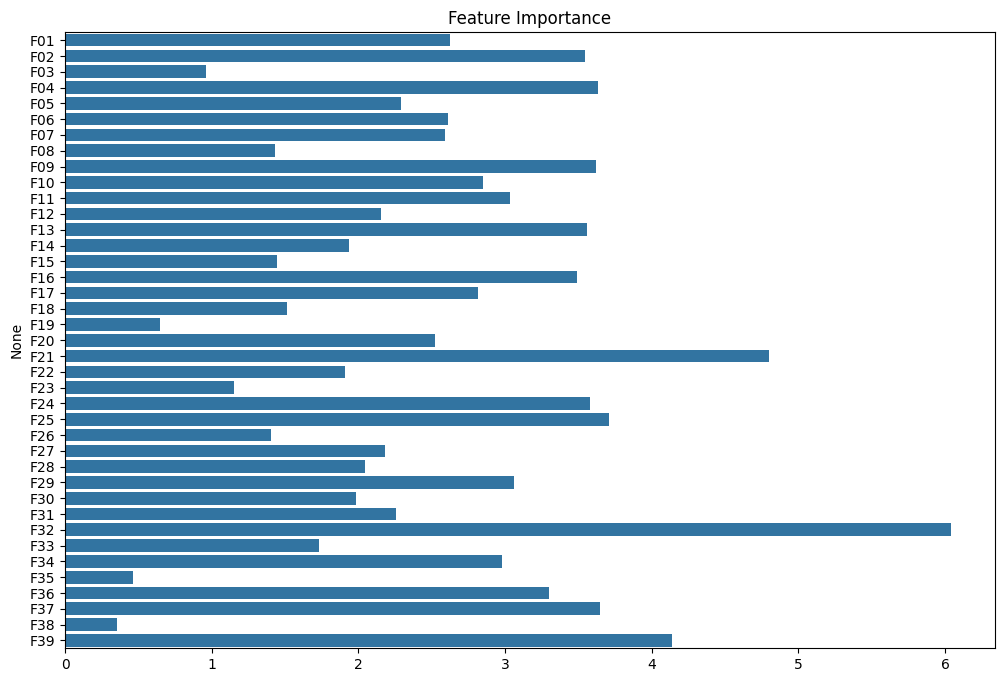

In [ ]:
# Feature importance 추출
importances = model.get_feature_importance()
feature_names = X_train.columns
import seaborn as sns

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance')
plt.show()

In [ ]:
# 피처 중요도를 내림차순으로 정렬
importances_sorted = sorted(importances, reverse=True)
importances_sorted

[6.039405639435767,
 4.8020865515401185,
 4.13795193965198,
 3.7101138341246958,
 3.6444232478813188,
 3.6310281122998154,
 3.6219476057668345,
 3.576729833194262,
 3.557947337999646,
 3.545158794796804,
 3.489173587706743,
 3.302426817809741,
 3.0581008545210464,
 3.034059881109098,
 2.979620972459944,
 2.850170460437579,
 2.818631370918035,
 2.6237871256552823,
 2.608634188978562,
 2.5923745341519377,
 2.5211176762473677,
 2.2886609869101058,
 2.2576577360388472,
 2.179094283209949,
 2.153678014454327,
 2.042199657735986,
 1.9856153597212673,
 1.9375508691191672,
 1.9113610920598882,
 1.730697258897856,
 1.5116787221557797,
 1.4468075297467091,
 1.4287361796350302,
 1.4014485388884281,
 1.1549411347443987,
 0.9602849515291684,
 0.6489771874421894,
 0.4601351415761799,
 0.35558498944815]

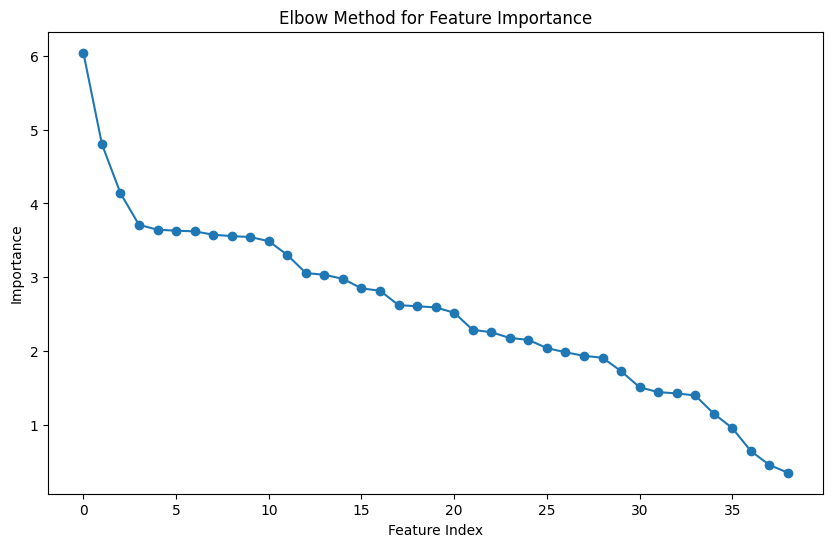

In [ ]:
# 피처 중요도를 내림차순으로 정렬
importances_sorted = sorted(importances, reverse=True)

# 피처 중요도 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(range(len(importances_sorted)), importances_sorted, marker='o')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Elbow Method for Feature Importance')
plt.show()

In [ ]:
# 엘보우 포인트 이후의 피처는 무시
threshold = 1.4

# 임계값 이상인 피처 선택
important_features = [feature for feature, importance in zip(feature_names, importances) if importance > threshold]

# 선택한 피처로 모델 학습
X_train_selected = X_train[important_features]
X_test_selected = X_test[important_features]

model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
auc_score = roc_auc_score(y_test, y_pred)


print(f"AUC after feature selection: {auc_score}")

0:	total: 300ms	remaining: 34m 58s
1000:	total: 4m 21s	remaining: 26m 4s
2000:	total: 8m 34s	remaining: 21m 25s
3000:	total: 12m 41s	remaining: 16m 54s
4000:	total: 16m 49s	remaining: 12m 36s
5000:	total: 21m 1s	remaining: 8m 24s
6000:	total: 25m 10s	remaining: 4m 11s
6999:	total: 29m 27s	remaining: 0us
AUC after feature selection: 0.5481872311705379


In [ ]:
# 임계값 3.5
#0:	total: 182ms	remaining: 21m 13s
#1000:	total: 2m 54s	remaining: 17m 26s
#2000:	total: 5m 51s	remaining: 14m 37s
#3000:	total: 8m 48s	remaining: 11m 43s
#4000:	total: 11m 43s	remaining: 8m 47s
#5000:	total: 14m 38s	remaining: 5m 51s
#6000:	total: 17m 31s	remaining: 2m 55s
#6999:	total: 20m 24s	remaining: 0us
#AUC after feature selection: 0.5327104886049363

# 임계값 1.4
#0:	total: 300ms	remaining: 34m 58s
#1000:	total: 4m 21s	remaining: 26m 4s
#2000:	total: 8m 34s	remaining: 21m 25s
#3000:	total: 12m 41s	remaining: 16m 54s
#4000:	total: 16m 49s	remaining: 12m 36s
#5000:	total: 21m 1s	remaining: 8m 24s
#6000:	total: 25m 10s	remaining: 4m 11s
#6999:	total: 29m 27s	remaining: 0us
#AUC after feature selection: 0.5481872311705379

In [ ]:
thresholds = [0.3, 0.6, 0.9, 1.2]

for threshold in thresholds:
    important_features = [feature for feature, importance in zip(feature_names, importances) if importance > threshold]
    X_train_selected = X_train[important_features]
    X_test_selected = X_test[important_features]

    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    auc_score = roc_auc_score(y_test, y_pred)

    print(f"Threshold: {threshold}, AUC: {auc_score}")

0:	total: 742ms	remaining: 1h 26m 36s
1000:	total: 4m 27s	remaining: 26m 42s
2000:	total: 8m 40s	remaining: 21m 39s
3000:	total: 12m 54s	remaining: 17m 12s
4000:	total: 17m 14s	remaining: 12m 55s
5000:	total: 21m 30s	remaining: 8m 35s
6000:	total: 25m 47s	remaining: 4m 17s
6999:	total: 30m 6s	remaining: 0us
Threshold: 0.3, AUC: 0.5488840550020793
0:	total: 296ms	remaining: 34m 32s
1000:	total: 4m 9s	remaining: 24m 56s
2000:	total: 8m 18s	remaining: 20m 46s
3000:	total: 12m 50s	remaining: 17m 6s
4000:	total: 17m 33s	remaining: 13m 9s
5000:	total: 22m 15s	remaining: 8m 53s
6000:	total: 26m 57s	remaining: 4m 29s
6999:	total: 31m 43s	remaining: 0us
Threshold: 0.6, AUC: 0.5482174904112072
0:	total: 334ms	remaining: 38m 58s
1000:	total: 4m 39s	remaining: 27m 54s
2000:	total: 9m 16s	remaining: 23m 9s
3000:	total: 13m 55s	remaining: 18m 32s
4000:	total: 18m 33s	remaining: 13m 54s
5000:	total: 23m 14s	remaining: 9m 17s
6000:	total: 27m 54s	remaining: 4m 38s


# Optuna로 최적의 하이퍼파라미터를 사용해 모델 정의

In [ ]:
# 최적의 하이퍼파라미터
best_params = {
    'iterations': 716,
    'depth': 6,
    'learning_rate': 0.1434452681311719,
    'random_strength': 9.636924231305613,
    'bagging_temperature': 0.8801310826837648,
    'border_count': 181,
    'l2_leaf_reg': 4.3754592812493405,
    'scale_pos_weight': 0.5297966866606383,
    'eval_metric': 'AUC',  # 모델 평가 척도
    'task_type': 'CPU',    # CPU 또는 GPU 설정
    'random_seed': 42      # 재현 가능한 결과를 위해 랜덤 시드 설정
}

# 모델 생성
model = CatBoostClassifier(**best_params)

In [ ]:
# Pool 객체를 사용하여 데이터 준비
train_pool = Pool(X_train, label=y_train)
validation_pool = Pool(X_test, label=y_test)

# 모델 학습
model.fit(
    train_pool,
    eval_set=validation_pool,
    early_stopping_rounds=500,  # 과적합 방지를 위해 조기 종료 설정
    verbose=100  # 학습 과정에서 진행 상황을 출력
)

0:	test: 0.5393806	best: 0.5393806 (0)	total: 399ms	remaining: 4m 45s
100:	test: 0.7117721	best: 0.7117721 (100)	total: 22.1s	remaining: 2m 14s
200:	test: 0.7315973	best: 0.7315973 (200)	total: 45s	remaining: 1m 55s
300:	test: 0.7374962	best: 0.7375085 (299)	total: 1m 5s	remaining: 1m 30s
400:	test: 0.7405721	best: 0.7405721 (400)	total: 1m 28s	remaining: 1m 9s
500:	test: 0.7426667	best: 0.7426667 (500)	total: 1m 48s	remaining: 46.7s
600:	test: 0.7442280	best: 0.7442280 (600)	total: 2m 11s	remaining: 25.2s
700:	test: 0.7453162	best: 0.7453162 (700)	total: 2m 31s	remaining: 3.25s
715:	test: 0.7455022	best: 0.7455038 (714)	total: 2m 34s	remaining: 0us

bestTest = 0.7455037783
bestIteration = 714

Shrink model to first 715 iterations.


In [ ]:
# 예측
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 평가 (AUC를 사용한 경우)
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC Score: {auc_score}")


Test AUC Score: 0.7455037783353915


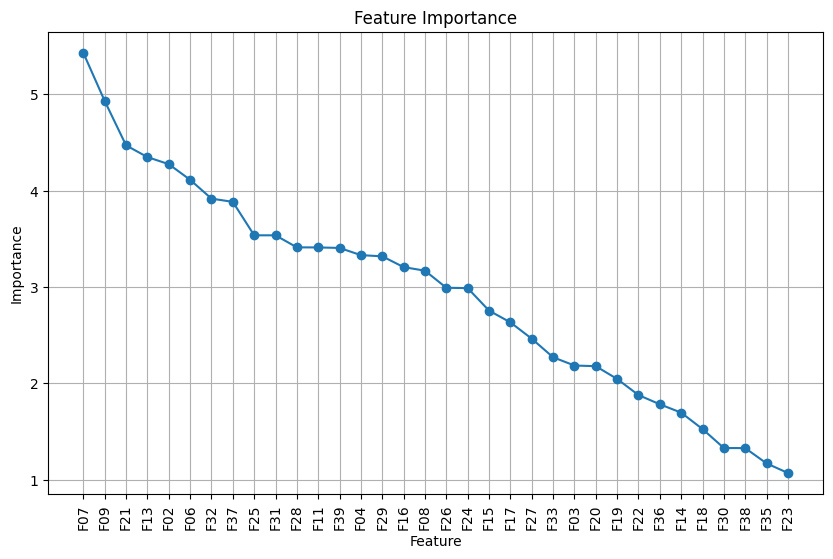

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Feature Importance 데이터 준비
data = {
    'Feature': ['F07', 'F09', 'F21', 'F13', 'F02', 'F06', 'F32', 'F37', 'F25', 'F31',
                'F28', 'F11', 'F39', 'F04', 'F29', 'F16', 'F08', 'F26', 'F24', 'F15',
                'F17', 'F27', 'F33', 'F03', 'F20', 'F19', 'F22', 'F36', 'F14', 'F18',
                'F30', 'F38', 'F35', 'F23'],
    'Importance': [5.430621, 4.931369, 4.471226, 4.349468, 4.276111, 4.113677,
                   3.918145, 3.884583, 3.537387, 3.537180, 3.412234, 3.411378,
                   3.406357, 3.331293, 3.319156, 3.207146, 3.169901, 2.992534,
                   2.989026, 2.755503, 2.633545, 2.463786, 2.271102, 2.185275,
                   2.178459, 2.045781, 1.878657, 1.782823, 1.695817, 1.525557,
                   1.328667, 1.327660, 1.169004, 1.069572]
}

# DataFrame 생성
df = pd.DataFrame(data)

# 중요도 값을 기준으로 내림차순 정렬
df_sorted = df.sort_values(by='Importance', ascending=False)

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(df_sorted['Feature'], df_sorted['Importance'], marker='o')
plt.xticks(rotation=90)  # 특성 이름이 길어지는 경우, X축 레이블 회전
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.grid(True)
plt.show()